In [1]:
# data science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# NLP libraries
from sentence_transformers import SentenceTransformer, util
import torch

# AI client
from groq import Groq

# Standard libraries
import random
import time
import joblib
from tqdm import tqdm

c:\Users\Hp\miniconda3\envs\llm-insea\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('../data/merged_data.csv')

### Feature Engineering

#### Social Crisis Labeling

In [11]:
# meaningful statistic: The 75th percentile (Top 25% of months)
social_cutoff = df['EventCount'].quantile(0.75) 

print(f"The threshold for Social Crisis is: {social_cutoff} events/month")

# Create the binary target
# If EventCount > cutoff -> 1 (Crisis), else -> 0 (Normal)
df['Y_Social_Label'] = (df['EventCount'] > social_cutoff).astype(int)

The threshold for Social Crisis is: 374.75 events/month


#### Economic Crisis Labeling

In [10]:
# Option A: Use strict economic rules (Domain Knowledge)
# e.g., Inflation > 3% is generally considered high
# high_inflation = df['INFLATION(%)'] > 3.0 
# high_unemployment = df['UNRATE(%)'] > 5.0

# Option B: Use relative history (Statistical)
# e.g., higher than the historical median
median_inflation = df['INFLATION(%)'].median()
median_unrate = df['UNRATE(%)'].median()

# Let's create a combined "Economic Stress" label
# It is "1" if EITHER inflation is high OR unemployment is high
df['Y_Economic_Label'] = (
    (df['INFLATION(%)'] > median_inflation) | 
    (df['UNRATE(%)'] > median_unrate)
).astype(int)

### Correlation Analysis

<Figure size 400x300 with 0 Axes>

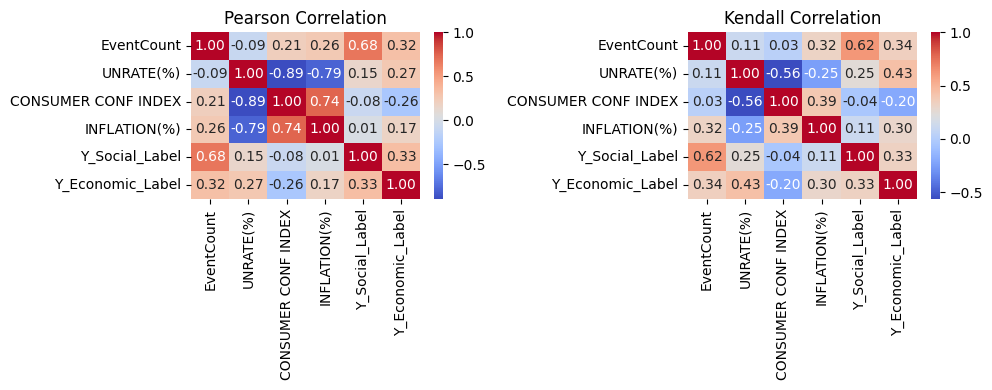

In [5]:
# correlation matrix heatmap
plt.figure(figsize=(4, 3))
df_corr = df.select_dtypes(include=[np.number])  # Select only numeric columns
corr_pearson = df_corr.corr(method='pearson')
corr_kendall = df_corr.corr(method='kendall')
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(corr_pearson, annot=True, fmt=".2f", cmap='coolwarm', ax=axes[0])
axes[0].set_title('Pearson Correlation')
sns.heatmap(corr_kendall, annot=True, fmt=".2f", cmap='coolwarm', ax=axes[1])
axes[1].set_title('Kendall Correlation')
plt.tight_layout()
plt.show()

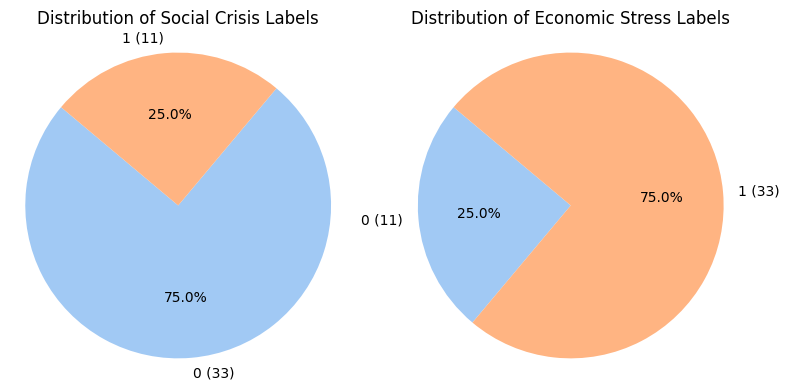

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Social Crisis Label Pie Chart
counts_social = df['Y_Social_Label'].value_counts().sort_index()
labels_social = [f"{idx} ({count})" for idx, count in zip(counts_social.index, counts_social.values)]
axes[0].pie(counts_social, labels=labels_social, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
axes[0].set_title('Distribution of Social Crisis Labels')
axes[0].axis('equal')

# Economic Crisis Label Pie Chart
counts_economic = df['Y_Economic_Label'].value_counts().sort_index()
labels_economic = [f"{idx} ({count})" for idx, count in zip(counts_economic.index, counts_economic.values)]
axes[1].pie(counts_economic, labels=labels_economic, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
axes[1].set_title('Distribution of Economic Stress Labels')
axes[1].axis('equal')

plt.tight_layout()
plt.show()

The data is umbalanced, we need to take this into account when evaluating the model performance.

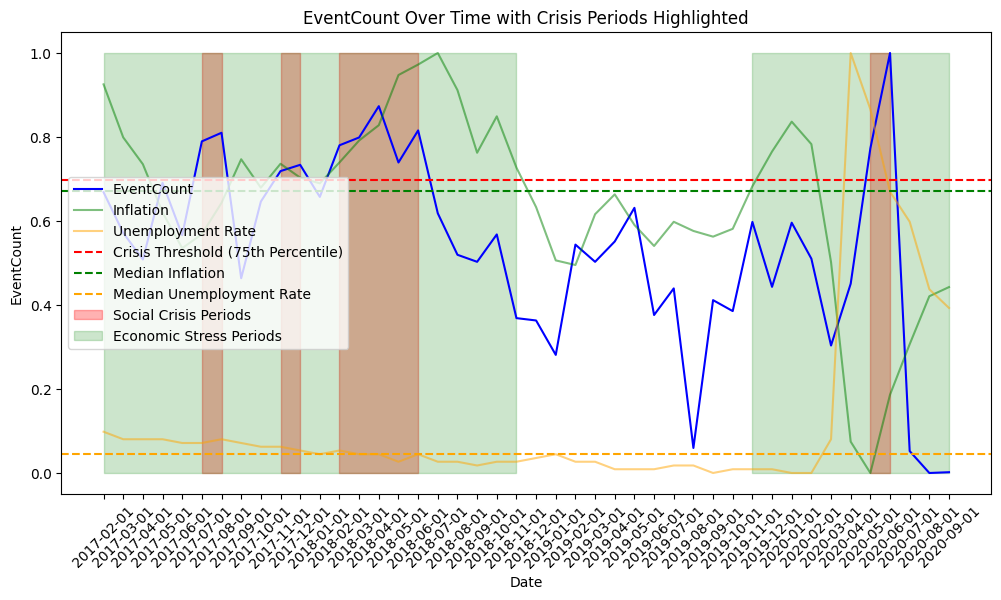

In [30]:
# plot the time series of EventCount with crisis periods highlighted
df_std = pd.read_csv('../data/merged_std_data.csv')

social_cutoff_std = df_std['EventCount'].quantile(0.75)

median_inflation_std = df_std['Inflation'].median()
median_unrate_std = df_std['Unemp'].median()


plt.figure(figsize=(12, 6))
plt.plot(df_std['Date'], df_std['EventCount'], label='EventCount', color='blue')
plt.plot(df_std['Date'], df_std['Inflation'], label='Inflation', color='green', alpha=0.5)
plt.plot(df_std['Date'], df_std['Unemp'], label='Unemployment Rate', color='orange', alpha=0.5)
plt.axhline(y=social_cutoff_std, color='red', linestyle='--', label='Crisis Threshold (75th Percentile)')
plt.axhline(y=median_inflation_std, color='green', linestyle='--', label='Median Inflation')
plt.axhline(y=median_unrate_std, color='orange', linestyle='--', label='Median Unemployment Rate')
plt.fill_between(df_std['Date'], 1, where=(df_std['EventCount'] > social_cutoff_std), color='red', alpha=0.3, label='Social Crisis Periods')
plt.fill_between(
    df_std['Date'],
    1,
    where=((df_std['Inflation'] > median_inflation_std) | (df_std['Unemp'] > median_unrate_std)).values,
    color='green',
    alpha=0.2,
    label='Economic Stress Periods'
)
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('EventCount')
plt.title('EventCount Over Time with Crisis Periods Highlighted')
plt.legend()
plt.show()

### Summarizing Headlines Column

- Go to https://huggingface.co/ and log in to your account.
- Click your profile icon (top right) and select **Settings**.
- In the left menu, click **Access Tokens**.
- Click **New token**.
- Give your token a name and select the **Read** role.
- Click **Generate** and copy the token (you won't see it again).
- save the token in your .env file as HF_TOKEN

![alt text](image.png)

In [7]:
# Connect to Hugging Face CLI and add your token
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()
hf_token = os.getenv("HF_TOKEN")
os.system(f'huggingface-cli login --token {hf_token}')

0

In [8]:
# This downloads a small (80MB) but powerful model from Hugging Face
embedder = SentenceTransformer('all-MiniLM-L6-v2')

# Define "Anchor Concepts" - We want headlines that are semantically close to these
QUERY_TEXTS = [
    "Civil unrest riots protests violence and police clashes",   # Social Anchor
    "Economic crisis inflation stock market crash and unemployment" # Economic Anchor
]
# Pre-compute the embeddings for our anchors
query_embeddings = embedder.encode(QUERY_TEXTS, convert_to_tensor=True)

In [47]:
def get_best_headlines_semantically(raw_text_block, sample_size=10000, top_k=75):
    """
    1. Splits huge text by '|'.
    2. Takes a random sample (e.g., 2000) to keep CPU time reasonable.
    3. Embeds them and finds the top_k (50) most relevant to Social/Economic risks.
    """
    if not isinstance(raw_text_block, str): return ""
    
    # Split by your delimiter
    all_headlines = raw_text_block.split('|')
    
    # CLEANING: Remove very short/empty strings
    all_headlines = [h.strip() for h in all_headlines if len(h) > 20]
    
    if not all_headlines: return ""

    # SAMPLING: Brute-forcing 250k lines is too slow. We sample 'sample_size' first.
    if len(all_headlines) > sample_size:
        candidates = random.sample(all_headlines, sample_size)
    else:
        candidates = all_headlines

    # EMBEDDING: Convert text to vectors
    # This runs on CPU. 2000 items takes about 5-10 seconds.
    candidate_embeddings = embedder.encode(candidates, convert_to_tensor=True)

    # SEARCH: Calculate Cosine Similarity
    # Compare every headline against our 2 Anchor Concepts
    cosine_scores = util.cos_sim(candidate_embeddings, query_embeddings)
    # Result is [num_candidates, 2]
    
    # We want headlines that match *either* Social OR Economic strongly.
    # So we take the max score across the 2 anchors for each headline.
    max_scores, _ = torch.max(cosine_scores, dim=1)
    
    # Select Top K highest scores
    # If we have fewer candidates than top_k, take all
    actual_k = min(top_k, len(candidates))
    top_results = torch.topk(max_scores, k=actual_k)
    
    # Retrieve the actual text
    best_headlines = [candidates[idx] for idx in top_results.indices]
    
    return ". ".join(best_headlines)

In [42]:
# save the dataset with new features
df.to_csv('../data/merged_data_with_labels.csv', index=False)

### Sentiment Analysis with LLM

#### Loading API Key and prompt template

In [31]:
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
client = Groq(api_key=GROQ_API_KEY)
with open('prompt.txt', 'r', encoding='utf-8') as f:
    PROMPT_TEMPLATE = f.read()

#### Helper Function to request LLM

In [51]:
def get_score(clean_text):
    """
    Injects text into prompt.txt template and queries Groq.
    """
    if not clean_text:
        return 5.0, 5.0 # Neutral fallback

    # Inject the text into the loaded template
    final_prompt = PROMPT_TEMPLATE.replace("{text}", clean_text)

    try:
        completion = client.chat.completions.create(
            messages=[{"role": "user", "content": final_prompt}],
            model="llama-3.1-8b-instant",
            response_format={"type": "json_object"},
            temperature=0
        )
        data = eval(completion.choices[0].message.content)
        return data['social_score'], data['economic_score']
        
    except Exception as e:
        if "429" in str(e):
            print("⏳ Rate limit hit. Sleeping 30s...")
            time.sleep(30)
            return get_score(clean_text) # Retry
        print(f"⚠️ LLM Error: {e}")
        return 5.0, 5.0

#### Loop over headlines and get sentiment scores

In [52]:
def get_scores(df=df):
    social_scores = []
    economic_scores = []
    
    print(f"Processing {len(df)} months...")

    for index, row in tqdm(df.iterrows(), total=len(df)):
        # print(f"\nMonth {index+1}/{len(df)}:")
        
        # Step A: Semantic Filter (CPU)
        t0 = time.time()
        clean_text = get_best_headlines_semantically(row['Headline'])
        # print(f"   - Filtered {len(row['Headline'])} chars in {time.time()-t0:.2f}s")
        
        # Step B: LLM Scoring (API)
        soc, eco = get_score(clean_text)
        social_scores.append(soc)
        economic_scores.append(eco)
        # print(f"   - Scores: Social={soc}, Econ={eco}")
        
        # Rate limit pause
        time.sleep(1)

    return social_scores, economic_scores

def train_and_save_models(df=df):
    # Train Models
    print("\nTraining Models...")
    X = df[['X_Social_Score', 'X_Economic_Score']]
    
    # Use class_weight='balanced' to handle imbalanced classes
    model_soc = LogisticRegression(class_weight='balanced').fit(X, df['Y_Social_Label'])
    model_eco = LogisticRegression(class_weight='balanced').fit(X, df['Y_Economic_Label'])
    
    # Save
    joblib.dump(model_soc, '../bin/model_social.pkl')
    joblib.dump(model_eco, '../bin/model_economic.pkl')
    print("Done! Models saved.")

In [53]:
# Assign Features
df['X_Social_Score'], df['X_Economic_Score'] = get_scores(df=df)
train_and_save_models(df=df)

Processing 44 months...


 98%|█████████▊| 43/44 [13:24<00:19, 19.13s/it]

⚠️ LLM Error: Connection error.


100%|██████████| 44/44 [13:38<00:00, 18.61s/it]


Training Models...
Done! Models saved.


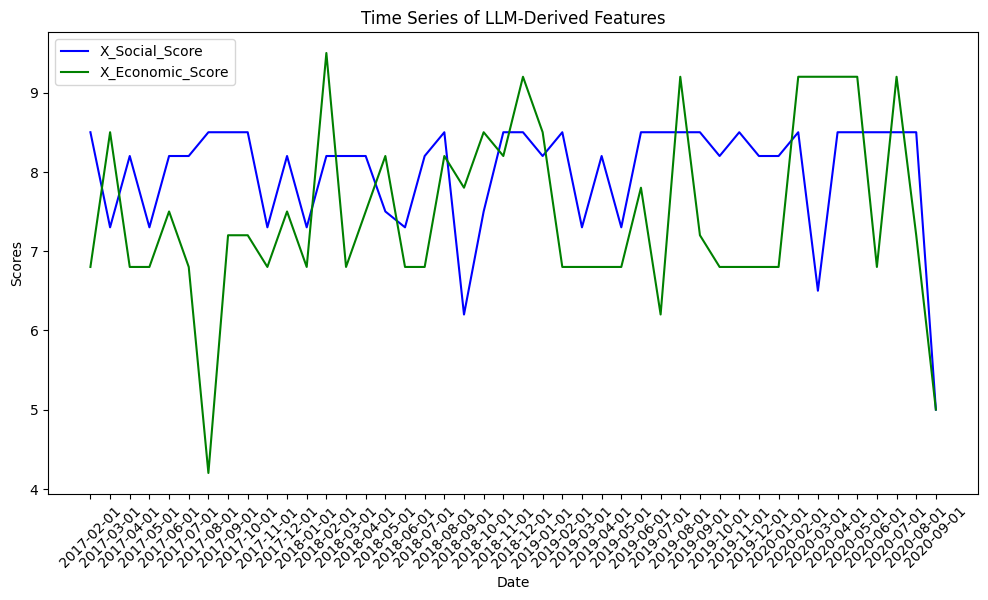

In [55]:
# plot time series of the new features
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['X_Social_Score'], label='X_Social_Score', color='blue')
plt.plot(df['Date'], df['X_Economic_Score'], label='X_Economic_Score', color='green')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Scores')
plt.title('Time Series of LLM-Derived Features')
plt.legend()
plt.show()

#### Evaluate Model Performance


SOCIAL RISK MODEL EVALUATION
              precision    recall  f1-score   support

      Normal       0.77      0.52      0.62        33
      Unrest       0.27      0.55      0.36        11

    accuracy                           0.52        44
   macro avg       0.52      0.53      0.49        44
weighted avg       0.65      0.52      0.55        44



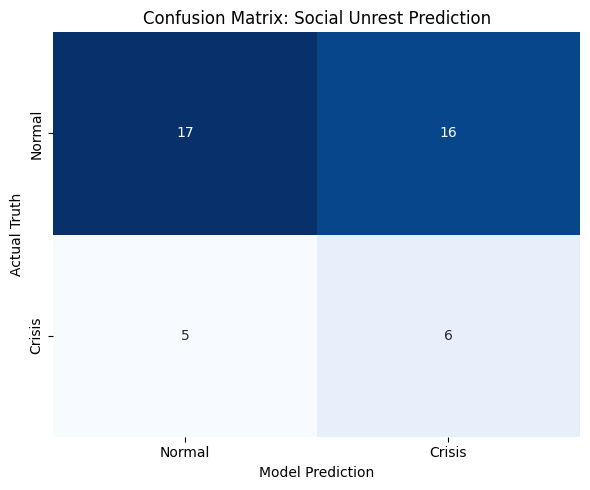


ECONOMIC RISK MODEL EVALUATION
              precision    recall  f1-score   support

      Normal       0.27      0.73      0.39        11
      Crisis       0.79      0.33      0.47        33

    accuracy                           0.43        44
   macro avg       0.53      0.53      0.43        44
weighted avg       0.66      0.43      0.45        44



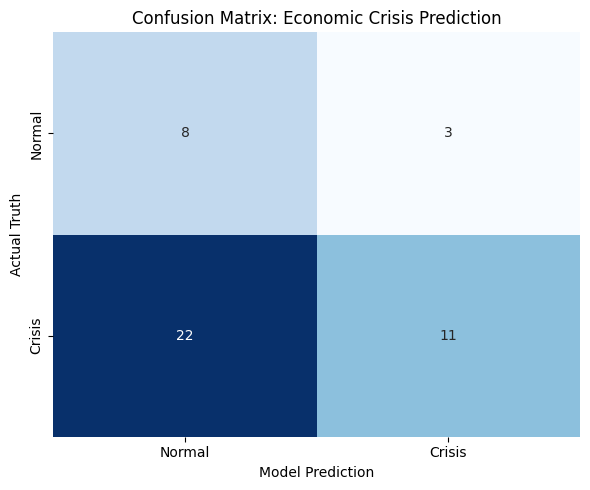

In [56]:
def plot_confusion_matrix(y_true, y_pred, title):
    """
    Creates a professional heatmap for your paper.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Normal', 'Crisis'],
                yticklabels=['Normal', 'Crisis'])
    plt.title(title)
    plt.ylabel('Actual Truth')
    plt.xlabel('Model Prediction')
    plt.tight_layout()
    plt.show()

def evaluate_performance():
    # 1. Load Resources
    model_soc = joblib.load('../bin/model_social.pkl')
    model_eco = joblib.load('../bin/model_economic.pkl')

    # Prepare Inputs
    X = df[['X_Social_Score', 'X_Economic_Score']]
    
    # --- EVALUATION 1: SOCIAL MODEL ---
    print("\n" + "="*40)
    print("SOCIAL RISK MODEL EVALUATION")
    print("="*40)
    
    y_pred_soc = model_soc.predict(X)
    
    # Metrics
    print(classification_report(df['Y_Social_Label'], y_pred_soc, target_names=['Normal', 'Unrest']))
    
    # Plot
    plot_confusion_matrix(
        df['Y_Social_Label'], 
        y_pred_soc, 
        "Confusion Matrix: Social Unrest Prediction"
    )

    # --- EVALUATION 2: ECONOMIC MODEL ---
    print("\n" + "="*40)
    print("ECONOMIC RISK MODEL EVALUATION")
    print("="*40)
    
    y_pred_eco = model_eco.predict(X)
    
    # Metrics
    print(classification_report(df['Y_Economic_Label'], y_pred_eco, target_names=['Normal', 'Crisis']))
    
    # Plot
    plot_confusion_matrix(
        df['Y_Economic_Label'], 
        y_pred_eco, 
        "Confusion Matrix: Economic Crisis Prediction"
    )

evaluate_performance()